In [167]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

# Preparing Data

In [168]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# proportion of validation set to training set
valid_size = 0.2  # DO NOT MODIFY !!!

# convert data to torch.FloatTensor
train_tfms = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
valid_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# FashionMNIST Dataset

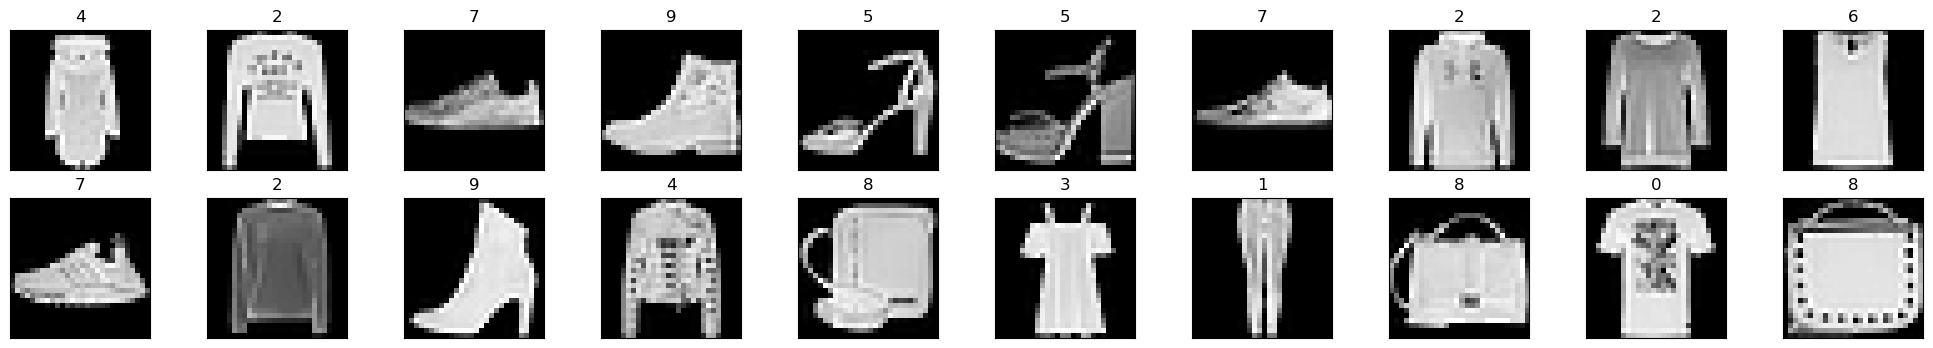

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [170]:
## define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layers
        self.fc1 = nn.Linear(28 * 28, 512) # DO NOT MODIFY !!!
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)    # DO NOT MODIFY !!!
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)    # DO NOT MODIFY !!!

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)      # DO NOT MODIFY !!!
        x = self.fc1(x)           # DO NOT MODIFY !!!
        # add hidden layer, with relu activation function
        x = F.relu(self.bn1(x))
        x = self.fc2(x)           # DO NOT MODIFY !!!
        x = F.relu(self.bn2(x))
        x = self.fc3(x)           # DO NOT MODIFY !!!
        return x

# move training to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# initialize the NN
model = Net().to(device)
print(model)

cuda
Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# Hyperparameters

In [171]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10  # DO NOT MODIFY !!!

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min = 0.0001)

# Training and Validation

In [172]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
# initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

        # update running training loss
        train_loss += loss.item()*data.size(0)

    # update the learning rate
    scheduler.step()

    ######################
    # validate the model #
    ######################
    model.eval()
    for data,target in valid_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(valid_loader.dataset)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

Epoch  1: Learning Rate: 0.001000 Training Loss: 0.394304 Validation Loss:0.076313
Validation loss decreased(inf-->0.076313). Saving model ..
Epoch  2: Learning Rate: 0.000978 Training Loss: 0.304214 Validation Loss:0.077585
Epoch  3: Learning Rate: 0.000914 Training Loss: 0.266546 Validation Loss:0.062965
Validation loss decreased(0.076313-->0.062965). Saving model ..
Epoch  4: Learning Rate: 0.000815 Training Loss: 0.239268 Validation Loss:0.066291
Epoch  5: Learning Rate: 0.000689 Training Loss: 0.218975 Validation Loss:0.060159
Validation loss decreased(0.062965-->0.060159). Saving model ..
Epoch  6: Learning Rate: 0.000550 Training Loss: 0.194404 Validation Loss:0.058338
Validation loss decreased(0.060159-->0.058338). Saving model ..
Epoch  7: Learning Rate: 0.000411 Training Loss: 0.172472 Validation Loss:0.058816
Epoch  8: Learning Rate: 0.000285 Training Loss: 0.155293 Validation Loss:0.059244
Epoch  9: Learning Rate: 0.000186 Training Loss: 0.139212 Validation Loss:0.057177
Va

# Plot Learning Rate Curve

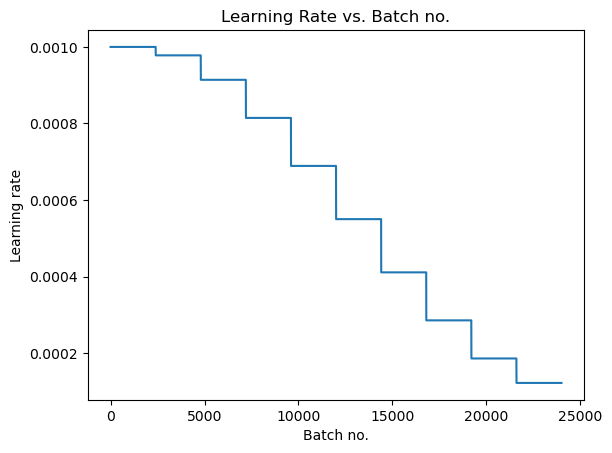

In [173]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

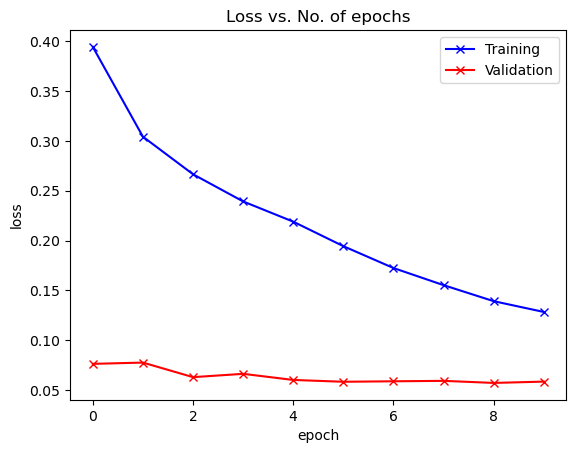

In [174]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [176]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Initialize the model
# model = Net().to(device)

# Load the model weights
# model.load_state_dict(torch.load('model_best.pt'))
model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)  # Move data to GPU
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

Test Loss: 0.295320

Test Accuracy of Class     0: 85.50% (855/1000)
Test Accuracy of Class     1: 97.60% (976/1000)
Test Accuracy of Class     2: 83.90% (839/1000)
Test Accuracy of Class     3: 92.70% (927/1000)
Test Accuracy of Class     4: 84.00% (840/1000)
Test Accuracy of Class     5: 96.50% (965/1000)
Test Accuracy of Class     6: 72.10% (721/1000)
Test Accuracy of Class     7: 96.40% (964/1000)
Test Accuracy of Class     8: 97.50% (975/1000)
Test Accuracy of Class     9: 95.00% (950/1000)

Test Accuracy (Overall): 90.12% (9012/10000)
